In [1]:
#install_libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import lyricsgenius
import nltk
import sentence_transformers

#install_tools
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

In [8]:
#genius.com_api_information
steawins_api_token = "vEH1inru7fMPSx1zn9VgqX0cypxCwLAAU2Ya1NWnljAhS5zjaHnSNVp03pvpnv2t"

genius = lyricsgenius.Genius(
    steawins_api_token,
    timeout=15,
    retries=3,
    skip_non_songs=True,
    remove_section_headers=True,
    excluded_terms = ['Remix', 'Version']
)

In [9]:
#store_primary_song_data
data = []
scores = []

#scrape_genius_for_StrayKids_songs
def get_jvke(limit=500):
    artist = genius.search_artist("Laufey", max_songs=limit, sort="title")
    for song in artist.songs:
        sentiment = sia.polarity_scores(song.lyrics)
        data.append({
            "Title": song.title,
            "Lyrics": song.lyrics,
            "Score": sentiment['compound']
        })
    time.sleep(1)
    df = pd.DataFrame(data)
    df.to_csv("jvke2.csv", index=False, encoding="utf-8")
    print("Saved:", len(df), "songs")
    return df

#create_csv_file
get_jvke(80)

Searching for songs by Laufey...

Song 1: "1999"
Song 2: "Above the Chinese Restaurant"
"Above the Chinese Restaurant (Instrumental)" is not valid. Skipping.
Song 3: "A Cautionary Tale"
Song 4: "A Cautionary Tale (English)"
"A Cautionary Tale (Instrumental)" is not valid. Skipping.
Song 5: "All At Once"
Song 6: "A Matter of Time Tour Dates"
"A Matter of Time Tour Setlist" is not valid. Skipping.
Song 7: "Beautiful Stranger"
"Beautiful Stranger (Instrumental)" is not valid. Skipping.
Song 8: "Beautiful Stranger (Live at The Symphony)"
Song 9: "Best Friend"
"Best Friend (Instrumental)" is not valid. Skipping.
Song 10: "Best Friend (Live at The Symphony)"
Song 11: "Bewitched"
"Bewitched (Instrumental)" is not valid. Skipping.
Song 12: "Bewitched (Live at the Hollywood Bowl)"
Couldn't find the lyrics section. Please report this if the song has lyrics.
Song URL: https://genius.com/Laufey-and-vikingur-olafsson-bewitched-rework-lyrics
Song 13: "Bewitched (Rework)"
Couldn't find the lyrics sec

,Title,Lyrics,Score
0,1999,Lyrics from \nSnippet\nAnd I guess you could b...,0.8381
1,Above the Chinese Restaurant,I still freeze when I look at these\nFaded pho...,0.8807
2,A Cautionary Tale,"Oh, heavens, hear my story, a cautionary tale\...",0.4768
3,A Cautionary Tale (English),Lyrics - Transcribed by Austin Menso\n\nOh hea...,0.9517
4,All At Once,How do you know if you like someone?\nDoes it ...,0.9873
...,...,...,...
75,Let You Break My Heart Again,Feeling kind of sick tonight\nAll I've had is ...,0.9831
76,Let You Break My Heart Again (Live),Feeling kind of sick tonight\nAll I've had is ...,0.9831
77,Let You Break My Heart Again (Live at the Holl...,Feeling kind of sick tonight\nAll I've had is ...,0.9831
78,Let You Break My Heart Again (Live at The Symp...,Feeling kind of sick tonight\nAll I've had is ...,0.9831


In [10]:
df = pd.read_csv("jvke2.csv")

#classify VADER scores
def emotions(score):
    if score > 0.3:
        return 'POSITIVE'
    elif score < -0.3:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

#create new CSV file w/ VADER classification terms
df['Emotional Scale'] = df['Score'].apply(emotions)
df.to_csv("jvke_song_emotions.csv", index=False)

In [11]:
df['Emotional Scale'].value_counts()

Emotional Scale
POSITIVE    54
NEGATIVE    19
NEUTRAL      7
Name: count, dtype: int64

In [12]:
#assign keywords to VADER polarity scores
label_map = {"NEGATIVE": 0, "POSITIVE": 1, "NEUTRAL": 2}
df["Label"] = df["Emotional Scale"].map(label_map)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Label"])

print("Train label distribution")
print(train_df["Label"].value_counts(),"/n")

print("Validation label distribution")
print(val_df["Label"].value_counts())

Train label distribution
Label
1    38
0    13
2     5
Name: count, dtype: int64 /n
Validation label distribution
Label
1    16
0     6
2     2
Name: count, dtype: int64


In [41]:
import requests

GENIUS_API_TOKEN = "vEH1inru7fMPSx1zn9VgqX0cypxCwLAAU2Ya1NWnljAhS5zjaHnSNVp03pvpnv2t"

#extract title of songs
def search_song_id(query):
    url = "https://api.genius.com/search"
    headers = {"Authorization": f"Bearer {GENIUS_API_TOKEN}"}
    params = {"q": query}

    r = requests.get(url, headers=headers, params=params).json()

    # take the first matching result
    try:
        result = r["response"]["hits"][0]["result"]
        return result["id"], result["full_title"]
    except:
        return None, None

#extract release date of songs
def fetch_release_date(title):
    # 1. Search for the song ID
    song_id, full_title = search_song_id(title)
    if song_id is None:
        return None  # couldn't find it

    # 2. Fetch song details
    url = f"https://api.genius.com/songs/{song_id}"
    headers = {"Authorization": f"Bearer {GENIUS_API_TOKEN}"}
    r = requests.get(url, headers=headers).json()

    # 3. Extract date
    try:
        return r["response"]["song"].get("release_date_for_display")
    except:
        return None

df = pd.read_csv("jvke_song_emotions.csv")
release_dates = []
for title in df["Title"]:
    release_dates.append(fetch_release_date(title))
df["Release Date"] = release_dates

#create Release Dates column in CSV file
df.to_csv("jvke_song_emotions.csv", index=False)

print("Done! New column saved.")

Done! New column saved.


In [42]:
from sentence_transformers import SentenceTransformer

#generate embeddings
embedder = SentenceTransformer("all-mpnet-base-v2")
df["Embedding"] = df["Lyrics"].apply(lambda x: embedder.encode(str(x)).tolist())
df.to_csv("jvke_song_emotions.csv", index=False)
df.head

<bound method NDFrame.head of                                                 Title  \
0                                                1999   
1                        Above the Chinese Restaurant   
2                                   A Cautionary Tale   
3                         A Cautionary Tale (English)   
4                                         All At Once   
..                                                ...   
75                       Let You Break My Heart Again   
76                Let You Break My Heart Again (Live)   
77  Let You Break My Heart Again (Live at the Holl...   
78  Let You Break My Heart Again (Live at The Symp...   
79                                       Like me back   

                                               Lyrics   Score Emotional Scale  \
0   Lyrics from \nSnippet\nAnd I guess you could b...  0.8381        POSITIVE   
1   I still freeze when I look at these\nFaded pho...  0.8807        POSITIVE   
2   Oh, heavens, hear my story, a cautiona

In [43]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#compare songs' vectors' cosine similarity and load it into similarity_matrix
embedding_matrix = np.vstack(df["Embedding"].values)
similarity_matrix = cosine_similarity(embedding_matrix)
similarity_matrix[:5, :5]

array([[1.        , 0.38437848, 0.38272161, 0.47188933, 0.27257997],
       [0.38437848, 1.        , 0.36680314, 0.45478271, 0.26993681],
       [0.38272161, 0.36680314, 1.        , 0.88290158, 0.38223377],
       [0.47188933, 0.45478271, 0.88290158, 1.        , 0.36886019],
       [0.27257997, 0.26993681, 0.38223377, 0.36886019, 1.        ]])

In [44]:
from sklearn.cluster import KMeans

#creating clusters by unsupervised learning through K-Means
k = 5
kmeans = KMeans(n_clusters=k, random_state = 42)
df["Cluster"] = kmeans.fit_predict(embedding_matrix)
df.to_csv("jvke_song_emotions.csv", index=False)
df[["Title", "Cluster"]]

C:\Users\igwin\Downloads\store\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,Title,Cluster
0,1999,2
1,Above the Chinese Restaurant,3
2,A Cautionary Tale,2
3,A Cautionary Tale (English),2
4,All At Once,1
...,...,...
75,Let You Break My Heart Again,1
76,Let You Break My Heart Again (Live),1
77,Let You Break My Heart Again (Live at the Holl...,1
78,Let You Break My Heart Again (Live at The Symp...,1


In [45]:
cluster_samples = {}
for x in df["Cluster"].unique():
    cluster_rows = df[df["Cluster"] == x]["Lyrics"]
    sample_size = min(3, len(cluster_rows))
    sample_texts = df[df["Cluster"] == x]["Lyrics"].sample(sample_size, random_state=42).tolist()
    cluster_samples[x] = sample_texts

cluster_samples

{np.int32(2): ["Oh, heavens, hear my story\nA cautionary tale\nOf how I came to be loved\nAnd how it came to fail\n\nA first time for lovers\nA first time in agony\nThe truths you will uncover\nWill knock you on your knees\n\nI gave it too much, I gave myself up\nI lost sight of all my dignity\nI've always been smart, my chameleon heart\nTook your draining personality and gave it to me\nI wanted to please you, this performance of a lifetime\nMy heart to you handed, you took it for granted\nAnd made me the villain, all alone\n\nI struggled through the winter\nFound cheat codes to your soul\nWas born to be a giver\nDestined to pay the toll\n\nI gave it too much, I gave myself up\nI lost sight of all my dignity\nI've always been smart, my chameleon heart\nTook your draining personality and gave it to me\nI wanted to please you, this performance of a lifetime\nMy heart to you handed, you took it for granted\nAnd made me the villain, all alone\n\nOh, inside you there's a guiltless child, wh

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
df["Lyrics"].isna().sum()
df["Lyrics"] = df["Lyrics"].fillna("")

# Get TF-IDF for all lyrics
tfidf = TfidfVectorizer(stop_words="english", max_features=2000)
X_tfidf = tfidf.fit_transform(df["Lyrics"])
terms = tfidf.get_feature_names_out()

# Get top words for each cluster
cluster_keywords = {}

for cluster_id in sorted(df["Cluster"].unique()):
    idx = df[df["Cluster"] == cluster_id].index
    cluster_tfidf = X_tfidf[idx].mean(axis=0).A1
    top_indices = cluster_tfidf.argsort()[::-1][:10]
    top_words = [terms[i] for i in top_indices]
    cluster_keywords[cluster_id] = top_words

cluster_keywords

{np.int32(0): ['dumb',
  'bitch',
  'danced',
  'tonight',
  'þú',
  'ég',
  'og',
  'hitting',
  'sure',
  'seeing'],
 np.int32(1): ['like',
  'day',
  'love',
  'll',
  'wish',
  'fall',
  'don',
  'heart',
  'bored',
  'oh'],
 np.int32(2): ['ooh',
  'know',
  'gave',
  'time',
  'fragile',
  'bewitched',
  'lost',
  'skin',
  'love',
  'forget'],
 np.int32(3): ['everybody',
  'falling',
  'mm',
  'guy',
  'love',
  'new',
  'clean',
  'oh',
  'shoulder',
  'sky'],
 np.int32(4): ['stranger',
  'beautiful',
  'mm',
  'grow',
  'know',
  'hair',
  'train',
  'remain',
  'squeeze',
  'thirteen']}

In [47]:
from groq import Groq
client = Groq(api_key="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")

cluster_names = {}

#auto-generate cluster names using Groq-hosted LLM
for c in sorted(df["Cluster"].unique()):
    # Combine the lyrics for this cluster
    combined = "\n\n---\n\n".join(cluster_samples[c])

    # Build the single-cluster prompt
    prompt = f"""
You are an NLP expert. Below is a set of song lyric excerpts from ONE cluster.

Your task:
- Identify one overarching emotional/theme title representing this cluster.

STRICT RULES:
- 3 to 5 words
- Plain text only
- No punctuation except spaces
- No lists
- No numbering
- No quotes
- No markdown
- Cannot have any words in common with the other titles
- Titles cannot be similar in the theme they convey
- Each title must convey a COMPLETELY different emotion/theme
- Output ONLY the theme title (NOTHING else)

CLUSTER {c} LYRICS:
{combined}

Now output exactly one theme title:
"""

    # Send the request for THIS cluster
    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role": "user", "content": prompt}]
    )

    # Extract title
    title = response.choices[0].message.content.strip()

    cluster_names[c] = title

cluster_names

{np.int32(0): 'Social Exhaustion',
 np.int32(1): 'Longing For Unrequited Love',
 np.int32(2): 'Toxic Love Remains',
 np.int32(3): 'Lost Youth Memories',
 np.int32(4): 'Missed Love Opportunities'}

In [48]:
df["Cluster Names"] = df["Cluster"].map(cluster_names)
df.to_csv("jvke_song_emotions.csv", index=False)

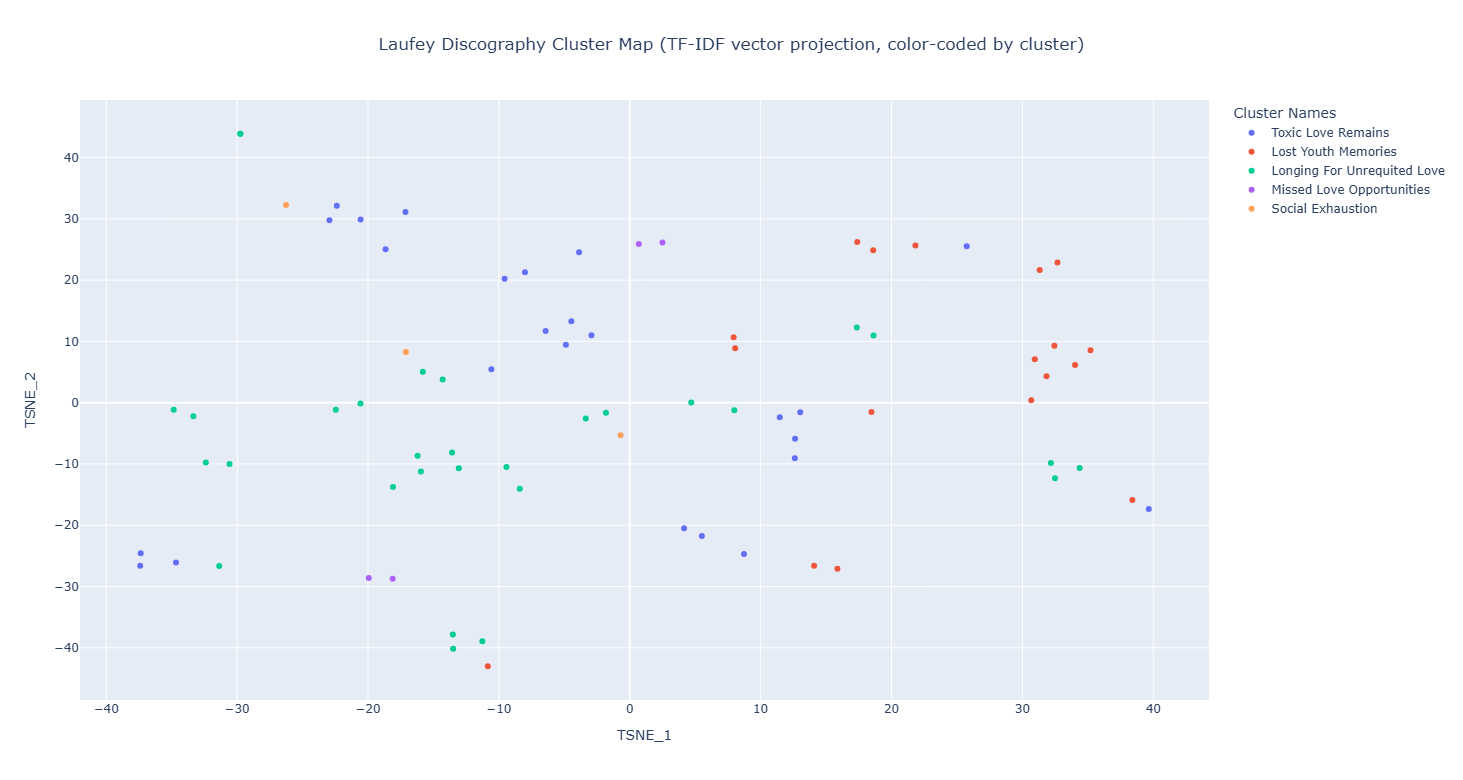

In [49]:
from sklearn.manifold import TSNE
import plotly.express as px

embedding_matrix = np.vstack(df["Embedding"].to_numpy())
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 5)
tsne_results = tsne.fit_transform(embedding_matrix)
df["TSNE_1"] = tsne_results[:, 0]
df["TSNE_2"] = tsne_results[:, 1]

#plot TF-IDF vector space with color-coded clusters
fig = px.scatter(
    df,
    x="TSNE_1",
    y="TSNE_2",
    color="Cluster Names",
    hover_data=["Title", "Cluster Names"],
    title="t-SNE Visualization of Song Emotion Clusters",
    height=780,
    width=920
)

#fix title position
fig.update_layout(title_text= "Laufey Discography Cluster Map (TF-IDF vector projection, color-coded by cluster)", title_x=0.5)



fig.show()

In [50]:
print(df['Release Date'])

0           July 6, 2018
1        August 26, 2022
2           May 18, 2018
3        August 22, 2025
4      February 14, 1985
             ...        
75       August 13, 2021
76    September 22, 2022
77      December 6, 2024
78         March 2, 2023
79     February 28, 2006
Name: Release Date, Length: 80, dtype: object


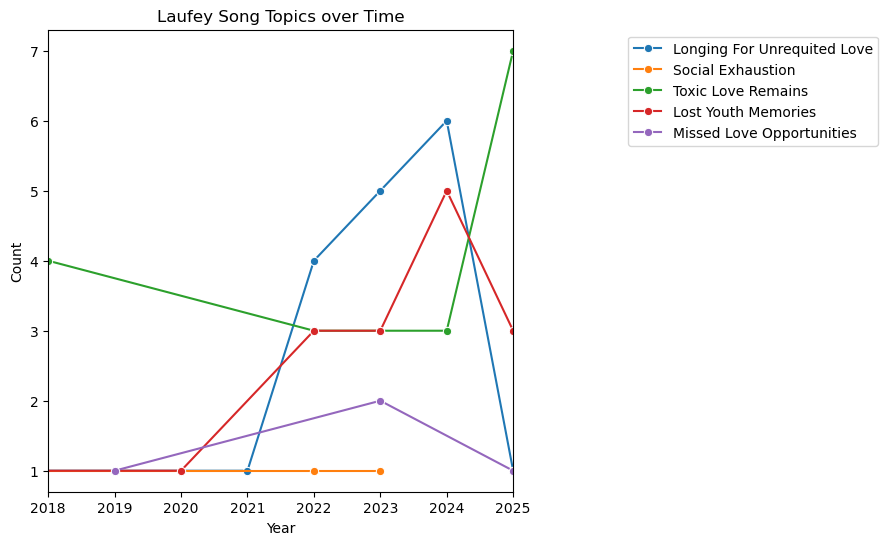

In [51]:
import seaborn as sns
#plot chronological frequency of all clusters
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df["Year"] = df["Release Date"].dt.year
timeline = df.groupby(["Year", "Cluster Names"]).size().reset_index(name = "Count")
plt.figure(figsize=(6,6))
sns.lineplot(data=timeline, x = "Year", y = "Count", hue = "Cluster Names", marker = "o")
plt.xlim(left=2018)
plt.xlim(right=2025)
plt.title("Laufey Song Topics over Time")
plt.legend(loc="upper right", bbox_to_anchor=(1.8, 1), ncol=1)
plt.show()

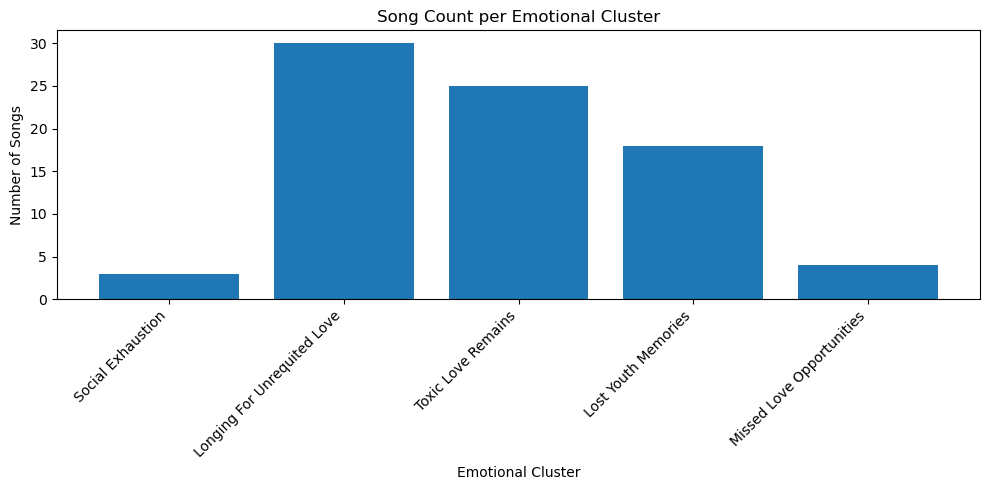

In [55]:
import matplotlib.pyplot as plt

# Count songs per cluster
cluster_counts = df["Cluster"].value_counts().sort_index()

# Map cluster numbers → LLM-generated names
labels = [cluster_names[c] for c in cluster_counts.index]

plt.figure(figsize=(10, 5))
plt.bar(labels, cluster_counts.values)

plt.title("Song Count per Emotional Cluster")
plt.xlabel("Emotional Cluster")
plt.ylabel("Number of Songs")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

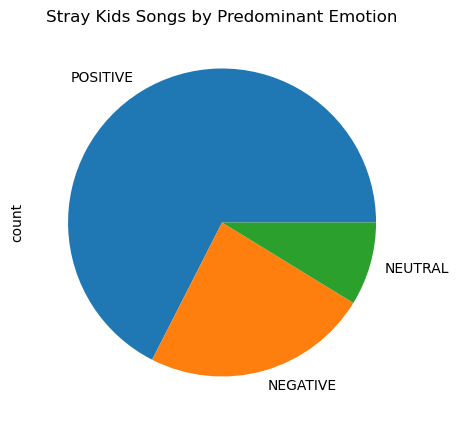

In [56]:
#plot numerical frequency of all clusters
plt.figure(figsize=(7,5))
df["Emotional Scale"].value_counts().plot(kind="pie")
plt.title("Stray Kids Songs by Predominant Emotion")
plt.show